# 1A.e - Enoncé 23 octobre 2018 (1)

Correction du premier énoncé de l'examen du 23 octobre 2018. 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

On sait d'après les dernières questions qu'il faudra tout répéter plusieurs fois. On prend le soin d'écrire chaque question dans une fonction.

## Q1 - échantillon aléatoire

Générer un ensemble de $N=1000$ couples aléatoires $(X_i,Y_i)$ qui vérifient :

* $X_i$ suit une loi normale de variance 1.
* $Y_i = 2 X_i + \epsilon_i$ où $\epsilon_i$ suit une loi normale de variance 1.

In [16]:
import numpy.random as rnd
import numpy

def random_mat(N):
    mat = numpy.zeros((N, 2))
    mat[:, 0] = rnd.normal(size=(N,))
    mat[:, 1] = mat[:, 0] * 2 + rnd.normal(size=(N,))
    return mat

N = 1000
mat = random_mat(N)
mat[:5]

array([[ 0.72457823,  0.67325493],
       [ 0.642962  ,  2.03136669],
       [ 0.94925674,  2.79166176],
       [ 0.36588917, -0.81003229],
       [-0.49339654, -1.97666224]])

## Q2 - matrice m1

On définit la matrice $M \in \mathbb{M}_{N,2}(\mathbb{R})$ définie par les deux vecteurs colonnes $(X_i)$ et $(Y_i)$. Choisir aléatoirement 20 valeurs dans cette matrice et les remplacer par ``numpy.nan``. On obtient la matrice $M_1$.

In [17]:
import random

def build_m1(mat, n=20):
    mat = mat.copy()
    positions = []
    for i in range(0, n):
        h = random.randint(0, mat.shape[0] * mat.shape[1] - 1)
        pos = h % mat.shape[0], h // mat.shape[0]
        positions.append(pos)
        mat[pos] = numpy.nan
    return mat, positions

m1, positions = build_m1(mat)
p = positions[0][0]
m1[max(p-2, 0):min(p+3, mat.shape[0])]

array([[ 0.50155553,  1.80382374],
       [ 1.2117257 ,  4.50648688],
       [        nan, -3.55788468],
       [-0.61610986, -1.58796412],
       [ 0.47502706,  0.17625956]])

## Q3 - moyenne

Calculer $\mathbb{E}{X} = \frac{1}{N}\sum_i^N X_i$ et $\mathbb{E}Y = \frac{1}{N}\sum_i^N Y_i$.

In [18]:
def mean_no_nan(mat):
    res = []
    for i in range(mat.shape[1]):
        ex = numpy.mean(mat[~numpy.isnan(mat[:, i]), i])
        res.append(ex)
    return numpy.array(res)

mean_no_nan(m1)

array([-0.00526488, -0.02134016])

## Q4 - matrice m2

Remplacer les valeurs manquantes de la matrice $M_1$ par la moyenne de leurs colonnes respectives. On obtient la matrice $M_2$.

In [19]:
def build_m2(mat):
    means = mean_no_nan(mat)
    m1 = mat.copy()
    for i in range(len(means)):
        m1[numpy.isnan(m1[:, i]), i] = means[i]
    return m1

m2 = build_m2(mat)
m2[max(p-2, 0):min(p+3, mat.shape[0])]

array([[ 0.50155553,  1.80382374],
       [ 1.2117257 ,  4.50648688],
       [-0.83813971, -3.55788468],
       [-0.61610986, -1.58796412],
       [ 0.47502706,  0.17625956]])

## Q5 - matrice m3

On trie la matrice $M_1$ selon la première colonne. On remplace chaque $y$ manquant par la moyenne des deux valeurs qui l'entourent. On recommence avec les $x$ manquant. On obtient la matrice $M_3$.

In [20]:
def fill_column(mat, col):
    nlin, ncol = mat.shape
    order = numpy.argsort(mat[:, 1-col])
    reverse_order = numpy.arange(0, nlin)
    for i, v in enumerate(order):
        reverse_order[v] = i
    bmat = mat[order, :]
    last = None
    replace = []
    for i in range(0, nlin):
        if numpy.isnan(bmat[i, col]):
            replace.append(i)
        else:
            last = bmat[i, col]
            if replace:
                current = bmat[i, col]
                if last is None:
                    for r in replace:
                        bmat[r, col] = current
                else:
                    for k, r in enumerate(replace):
                        bmat[r, col] = last + (current - last) * float(k) / len(replace)
            replace = []
            
    if len(replace) > 0:
        # Il reste des valeurs manquantes à la fin.
        for r in replace:
            bmat[r, col] = last        
    
    return bmat[reverse_order, :]

def build_m3(mat):
    m3 = mat
    for i in range(0, mat.shape[1]):
        m3 = fill_column(m3, i)
    return m3

m3 = build_m3(m1)
m3[max(p-2, 0):min(p+3, mat.shape[0])]

array([[ 0.50155553,  1.80382374],
       [ 1.2117257 ,  4.50648688],
       [-1.32273873, -3.55788468],
       [-0.61610986, -1.58796412],
       [ 0.47502706,  0.17625956]])

On vérifie avec *pandas* que tout s'est bien passe.

In [22]:
from pandas import DataFrame
df = DataFrame(m3)
df[df.iloc[:, 0].isnull()]

,0,1


In [23]:
df[df.iloc[:, 1].isnull()]

,0,1


Tout va bien.

## Q6 - norme

On a deux méthodes pour compléter les valeurs manquantes, quelle est la meilleure ? Il faut vérifier numériquement en comparant $\parallel M-M_2 \parallel^2$ et $\parallel M-M_3 \parallel^2$.

In [24]:
def distance(m1, m2):
    d = m1.ravel() - m2.ravel()
    return d @ d

d2 = distance(mat, m2)
d3 = distance(mat, m3)
d2, d3

(0.0, 25.01234488984453)

## Q7 - répétition

Une experience réussie ne veut pas dire que cela fonctionne. Recommencer 10 fois en changeant le nuages de points et les valeurs manquantes ajoutées.

In [25]:
def repetition(N=1000, n=20, nb=10):
    res = []
    for i in range(nb):
        mat = random_mat(N)
        m1, _ = add_nan(mat, n)
        m2 = build_m2(m1)
        m3 = build_m3(m1)
        d2, d3 = distance(mat, m2), distance(mat, m3)
        res.append((d2, d3))
    return numpy.array(res)

repetition()

array([[51.13819425, 22.20859228],
       [30.30464597, 23.7188251 ],
       [52.09377307, 19.05235921],
       [46.19705702,  8.61684035],
       [42.9106715 , 21.64300829],
       [41.66131594, 17.65469097],
       [68.6101583 , 14.17057596],
       [30.64368958, 30.29736156],
       [70.57553993, 43.71410341],
       [52.82978116,  7.81705761]])

## Q8 - plus de valeurs manquantes

Et si on augmente le nombre de valeurs manquantes, l'écart se creuse-t-il ou se réduit -il ? Montrez-le numériquement.

In [26]:
diff = []
for n in range(10, 1000, 10):
    res = repetition(n=n, nb=10)
    diff.append(res.mean(axis=0) / n)
diff = numpy.array(diff)
diff[:5]

array([[2.80853567, 1.09844185],
       [3.3144222 , 1.52377609],
       [3.65047397, 1.52739417],
       [2.66507784, 1.25241461],
       [2.81706126, 1.23633396]])

In [27]:
%matplotlib inline

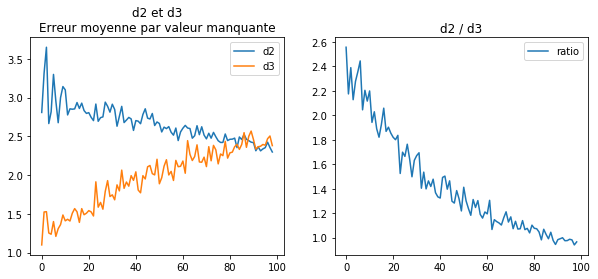

In [28]:
import pandas
df = pandas.DataFrame(diff, columns=["d2", "d3"])
df["ratio"] = df["d2"] / df["d3"]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
df[["d2", "d3"]].plot(ax=ax[0])
df[["ratio"]].plot(ax=ax[1])
ax[0].set_title("d2 et d3\nErreur moyenne par valeur manquante")
ax[1].set_title("d2 / d3");

Plus il y a de valeurs manquantes, plus le ratio tend vers 1 car il y a moins d'informations pour compléter les valeurs manquantes autrement que 

## Q9 - 1 valeur manquante ?

S'il n'y qu'une valeur manquante, peut-on sans changer le résultat se passer de tri pour avoir un coût linéaire ?

Si la valeur manquante est dans la colonne 0, il suffit de chercher l'intervalle le plus petit qui encadre la valeur sur la colonne 1 puis de faire la moyenne des valeurs sur les deux valeurs sur la colonne 0.

In [29]:
def build_m3_just1(mat):
    for i in range(0, mat.shape[0]):
        if numpy.isnan(mat[i, 0]):
            pos = i, 0
            col = 1
            value = mat[i, 1]
            break
        if numpy.isnan(mat[i, 1]):
            pos = i, 1
            col = 0
            value = mat[i, 0]
            break
    
    imin, imax = None, None
    for i in range(0, mat.shape[0]):
        if i == pos[0]:
            continue
        if imin is None or mat[imin, col] < mat[i, col] <= value:
            imin = i
        if imax is None or mat[imax, col] > mat[i, col] >= value:
            imax = i
    mat = mat.copy()
    mat[pos] = (mat[imin, col] + mat[imax, col]) / 2
    return mat

mat = numpy.array([[10, 11],
                   [9, 10],
                   [8, numpy.nan],
                   [7, 9],
                   [6, 8]])
build_m3_just1(mat)

array([[10. , 11. ],
       [ 9. , 10. ],
       [ 8. ,  9.5],
       [ 7. ,  9. ],
       [ 6. ,  8. ]])

## Q10 - plus de deux colonnes ?

Pour cette question, vous avez le choix entre implémenter la solution que vous proposez à la question précédente ou proposer une façon d'étendre la méthode dans le cas où il y a 3 dimensions.

Dans ce cas de notre matrice, on utilise l'autre colonne pour ordonner les lignes. Avec plusieurs colonnes, il faudrait choisir la colonne la plus corrélée.